<a href="https://colab.research.google.com/github/JefferyCuiWU/BME-589-Project/blob/main/pre_trained_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install ldct-benchmark

In [ ]:
!pip install ldct-benchmark

# Import Packages

In [ ]:
from ldctbench.hub import load_model
import torch
import numpy as np
from ldctbench.hub import load_model, Methods
from ldctbench.evaluate import preprocess, denormalize
import matplotlib.pyplot as plt
import os

# Mount google colab (Optional)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Preprocessing function

In [ ]:
!cp drive/MyDrive/processing/preprocessing.py /content/    # Make it comment if you do not use google drive

In [ ]:
import preprocessing # I comment some parts of this function

# Read the Data

In [ ]:
CT_data_dir='/content/drive/MyDrive/CT_data'
data_dir=sorted(os.listdir(CT_data_dir))
ct_volume=[]
for i in range(len(data_dir)):
  data_dir[i]=os.path.join(CT_data_dir, data_dir[i])
  ct_volume.append(preprocessing.load_ct_series_with_rescale(data_dir[i])) #save input data as a list


# Donoise The Data

**In this section we define 4 function includes:**

**1. denoiser:** to use different model to reconstruct LDCT images

**2. show_outcome:** to display outcome

**3. test_method:** to test model to denoise every slices and save the   
result as numpy format

**4. save_result:** to help make directories and files



In [ ]:
def denoiser(method, slices):
  #method = "redcnn"
            # "cnn10"
            # "wganvgg"
            # "resnet"
            # "qae"
            # "dugan"
            # "transct"
            # "bilateral"
  # Setup model
  net = load_model(method)
  # Define image
  x = slices # ... some numpy array of shape [1, 512, 512] you wish to denoise
  # Preprocess and normalize input
  x_t = preprocess(x, method=method)
  # Convert x_t to torch tensor
  #new_x_tensor = torch.from_numpy(x_t).float()
  # Apply network
  y_hat = net(x_t)
  # Denormalize
  y_hat = denormalize(y_hat, method=method)
  return y_hat

In [ ]:
def show_outcome(input, result, z, method_name):
  plt.subplot(1,2,1)
  plt.imshow(input, cmap='gray')
  plt.title(f" True image Axial Slice (index={z})")
  plt.xlabel("Slice (Z-axis)")
  plt.ylabel("Width (X-axis)")
  plt.colorbar(label="Hounsfield Units (HU)")
  plt.axis("on")
  plt.tight_layout()


  # Detach y_hat from the computation graph before converting to NumPy
  #tensor_image = result.permute(1, 2, 0)
  plt.subplot(1,2,2)
  plt.imshow(result.detach().squeeze(), cmap='gray')
  plt.title(f" Denoised image Axial Slice (index={z}),(method: {method_name})")
  plt.xlabel("Slice (Z-axis)")
  plt.ylabel("Width (X-axis)")
  plt.colorbar(label="Hounsfield Units (HU)")
  plt.axis("on")
  plt.tight_layout()
  plt.show()

In [ ]:
def test_method(method):
  for i in range(len(ct_volume)):
    for j in range(ct_volume[i].shape[0]):
      x=ct_volume[i][j]
      new_x=x.reshape(1, x.shape[0],x .shape[1])
      y_hat=denoiser(method, new_x)
      #show_outcome(x, y_hat, j, method)
      # Convert y_hat to numpy array
      y_hat=y_hat.detach().numpy()

      # Save result as numpy array in related folder
      save_result(CT_data_dir, method, i, j, y_hat)

In [ ]:
def save_result(CT_data_dir, method_name, counter, slice_num, result):
  save_result_dir=CT_data_dir+'/methods/'+method_name
  if os.path.exists(save_result_dir)==False:
    os.makedirs(save_result_dir)
  save_slices_dir=save_result_dir+'/'+'CT'+str(counter)
  if os.path.exists(save_slices_dir)==False:
    os.makedirs(save_slices_dir)
  slice_name='1-'+"{:03d}".format(slice_num+1)+'_'+method_name
  save_path=save_slices_dir+'/'+slice_name+'.npy'
  np.save(save_path, result) #result is numpy array



# Test Methods on The Data

I choose "cnn10" method to denoise the data

In [ ]:
method='cnn10'
test_method(method)

# Testing just for 1 data (Optional)

In [ ]:
new_x=ct_volume[1][1].reshape(1, ct_volume[1][1].shape[0], ct_volume[1][1].shape[1])

In [ ]:
import numpy as np
from ldctbench.hub import load_model, Methods
from ldctbench.evaluate import preprocess, denormalize#, denormalize
#from ldctbench.evaluate.utils import denormalize, normalize
method = "wganvgg" #Methods.RESNET # method="resnet" also works
# Setup model
net = load_model(method)
# Define image
x = new_x # ... some numpy array of shape [1, 512, 512] you wish to denoise
# Preprocess and normalize input
x_t = preprocess(x, method=method)
new_x_tensor = torch.from_numpy(new_x).float()
# Apply network
y_hat = net(new_x_tensor)
# # Denormalize
# y_hat = denormalize(y_hat, method=method)

Download wganvgg.pt to /root/.cache/ldctbench: 100%|██████████| 225k/225k [00:00<00:00, 272kiB/s]


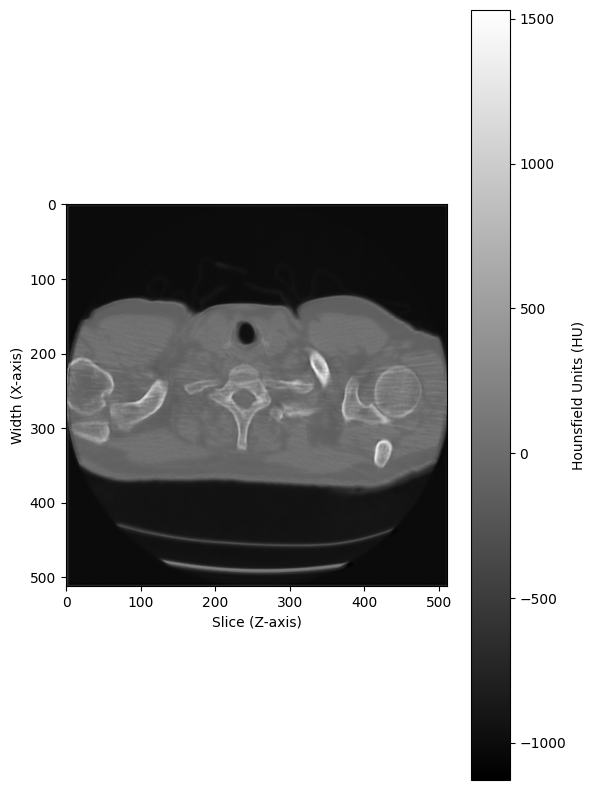

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 8))
# Detach y_hat from the computation graph before converting to NumPy
tensor_image = y_hat.permute(1, 2, 0)
plt.imshow(tensor_image.detach().squeeze(), cmap='gray')
plt.xlabel("Slice (Z-axis)")
plt.ylabel("Width (X-axis)")
plt.colorbar(label="Hounsfield Units (HU)")
plt.axis("on")
plt.tight_layout()
plt.show()